__Chapter 12 - Implementing a Multilayer Artificial Neural Network from Scratch__

1. [Import](#Import)
1. [Modeling complex functions with artificial neural networks](#Modeling-complex-functions-with-artificial-neural-networks)
    1. [Activating a neural network via forward propagation](#Activating-a-neural-network-via-forward-propagation)
1. [Classifying handwritten digits](#Classifying-handwritten-digits)
1. [Implementing a multilayer perceptron](#Implementing-a-multilayer-perceptron)
    1. [Homegrown implementation](#Homegrown-implementation)
1. [Training an artificial neural network](#Training-an-artificial-neural-network)
    1. [Logistic cost function refresher](#Logistic-cost-function-refresher)
    1. [Computing the logistic cost function](#Computing-the-logistic-cost-function)
    1. [Developing intuition for backpropagation](#Developing-your-intuition-for-backpropagation)
    1. [Training neural networks via backpropagation](#Training-neural-networks-via-backpropagation)

# Import

<a id = 'Import'></a>

In [1]:
# standard libary and settings
import os
import sys
import importlib
import itertools
from io import StringIO
import warnings

warnings.simplefilter("ignore")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
import sklearn.base as base
import sklearn.cluster as cluster
import sklearn.datasets as datasets
import sklearn.decomposition as decomposition
import sklearn.ensemble as ensemble
import sklearn.feature_extraction as feature_extraction
import sklearn.feature_selection as feature_selection
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import sklearn.neighbors as neighbors
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
import sklearn.svm as svm
import sklearn.tree as tree
import sklearn.discriminant_analysis as discriminant_analysis
import sklearn.utils as utils

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt

# custom extensions and settings
sys.path.append("/home/mlmachine") if "/home/mlmachine" not in sys.path else None
sys.path.append("/home/prettierplot") if "/home/prettierplot" not in sys.path else None

import mlmachine as mlm
from prettierplot.plotter import PrettierPlot
import prettierplot.style as style

# magic functions
%matplotlib inline

# Modeling complex functions with artificial neural networks

A fully connected network, also known as a multilayer perceptron (MLP), has one input layer of neurons, one hidden layer and one output layer. The units in the hidden layer are fully connected to the input layer, and the output layer is fully connected to the hidden layer. If more than one hidden layer is present then the MLP is considered to be a deep artificial neural network.

Each neuron, or activation unit, can be identified by its position amongst the other activation neurons and the layer in which it appear - $a_i^l$ is the $i$th neuron in the $l$th layer. For simplicity, this walkthrough will use the $l$ values of $in, h, out$ to describe the input, hidden and output layer. So $a_i^{out}$ is the $i$th activation unit of the outer layer. The input and hidden layers each have bias units, $a_0^{in}$ and $a_0^{out}$ and these are set to one. This means the input layer is just the input values plus the bias unit:

$$
a^{in} 
= 
\begin{bmatrix} a_0^{in} \\ a_1^{in} \\ \vdots \\  a_m^{in} \end{bmatrix}
=
\begin{bmatrix} 1 \\ x_1^{in} \\ \vdots \\  x_m^{in} \end{bmatrix}
$$ 

Each activation unit in layer $l$ is connected to all of the units in layer $l$ + 1 by a weight coefficient. As an example, the connection between the $k$th unit layer $l$ to the $j$th in layer $l$ + 1 is written as $w_{k,j}^l$. So the weight matrix that connects the input layer to the hidden layer is $\mathbf{W}^{h}$, the weight matrix that connects the hidden layer to the output layer is $\mathbf{W}^{out}$. The weight matrix that connects, for example, the input and hidden layers is $\mathbf{W}^h \in \mathbb{R}^{m \times d}$, where $d$ is the number of hidden units and $m$ is the numnber of input units (including bias).

Having one unit in the output layer is sufficient for a binary classificaiton task, but having more than one enables multiclass classification through one-hot vector representation of the multiclass labels.:
$$
0 
= 
\begin{bmatrix} 1 \\ 0 \\ 0 \end{bmatrix}
1 
= 
\begin{bmatrix} 0 \\ 1 \\ 0 \end{bmatrix}
2 
= 
\begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}
$$


<a id = 'Modeling-complex-functions-with-artificial-neural-networks'></a>

## Activating a neural network via forward propagation

The MLP learning procedure in three steps:

1. Starting at the input layer, forward propagate the patterns of the training data through the network to generate an output
2. Using the output, calculate the error to be minimized using a cost function
3. Backpropagate the error, find its derivative with respect to each weight in the network, then update the model

In feedforward networks, each layer serves as the input to the next layer without any loops. This contrasts with recurrent neural networks. The three steps above are repeated for multiple epochs to learn the best weights, and then forward propagation is used to the calculate the network output and apply a threshold function to obtain the predicted class labels represented in the one-hot format above. Describing each step in more detail:

The first activation unit in the hidden layer $a_1^{h}$ is connected to all units in the input layer, and is calculated by:

$$
z_1^h = a_0^{in}w_{0,1}^h + a_1^{in}w_{1,1}^h + ... a_m^{in}w_{m,1}^h
$$
$$
a_1^h = \phi\big(z_1^h\big)
$$
$z_1^h$ is the net input and $\phi(\cdot)$ is the activation function that acts on $z_1^h$. This activation function need to be differentiable to learn the weights that connect the neurons using a gradient-based approach. Non-linear activation function are also possible and are used to solve complex problems like image classification. One familiar non-linear activation function is the sigmoid function, which arose in the context of logistic regression:

$$
\phi(z) = \frac{1}{1 + e^{-z}}
$$

This is an S-shaped curve that maps the input $z$ onto a logistic distribution that ranges from 0 to 1 and cross the y-axis at $z$ = 0. Given this, we can think of each neuron as logistic regression units that return values in the numeric range of 0 to 1. To describe this activation function in linear algebra notation:

$$
\begin{equation}
\textbf{z}^{h} = \textbf{a}^{in}\textbf{W}^h
\\
\textbf{a}^h = \phi\big(\textbf{z}^h\big)
\end{equation}
$$

$\textbf{a}^{in}$ is the 1 x $m$ dimensional feature vector for a sample $\textbf{x}^{in}$, plus the bias unit. $\textbf{W}^{h}$ is the $m$ x $d$ dimensional weight matrix where $d$ is the number of units in the hidden layer. Through matrix-vector multiplication, we obtain a 1 x $d$ dimensional net input vector $\textbf{z}^h$ to be used to calculate the activation $\textbf{a}^{h}$ ($\textbf{a}^{h} \in \mathbb{R}^{1 \times d}$). This computation can be generalized to all $n$ samples in the training set by:

$$
\textbf{Z}^{h} = \textbf{A}^{in}\textbf{W}^{h}
$$

In this representation, $\textbf{A}^{in}$ is an $n$ x $m$ matrix, and the matrix-matrix multiplication results in an $n$ x $d$ dimensional net input matrix $\textbf{Z}^{h}$. Lastly, apply the activation function $\phi(\cdot)$ to each value in the net input matrix to get the $n$ x $d$ dimensional matrix $\textbf{A}^{h}$ for the next layer, which in this case is the output layer:

$$
A^h = \phi\big(\textbf{Z}^{h}\big)
$$

Just as above, we can write the activation function of the output layer in vectorized form for multiple samples:
$$
\textbf{Z}^{out} = \textbf{A}^{h}\textbf{W}^{out}
$$

In this last step, we multiply the $d$ x $t$ matrix $\textbf{W}^{out}$ (where $t$ is the number of output units) by the $n$ by $d$ dimensional matrix $\textbf{A}^{h}$ to obtain the $n$ by $t$ dimensional matrix $\textbf{Z}^{out}$, where the columns in this matrix represent the outputs for each sample. The last step is to apply the sgmoid activation function to obtain the numeric valued ouput of the network:

$$
\textbf{A}^{out} = \phi\big(\textbf{Z}^{out}\big), \textbf{A}^{out} \in \mathbb{R}^{n \times t}
$$

<a id = 'Activating-a-neural-network-via-forward-propagation'></a>

# Classifying handwritten digits

Implement and train our first MLP to classify handwritten digits from the Mixed National Institute of Standards and Techngology (MNIST). It consists of handwritten digits from 250 people - half high school students and half Census Bureau employees.

<a id = 'Classifying-handwritten-digits'></a>

In [2]:
# Load data and print dimensions
dfTrain = pd.read_csv("../../data/kaggleMNIST/train.csv", sep=",")
dfTest = pd.read_csv("../../data/kaggleMNIST/test.csv", sep=",")

print("Training data dimensions: {}".format(dfTrain.shape))
print("Test data dimensions: {}".format(dfTest.shape))

# separate
dfTrainLabel = dfTrain["label"]
dfTrain = dfTrain.drop(labels="label", axis=1)

Training data dimensions: (42000, 785)
Test data dimensions: (28000, 784)


In [3]:
# train/test split
XTrain, XTest, yTrain, yTest = model_selection.train_test_split(
    dfTrain, dfTrainLabel, test_size=0.2
)

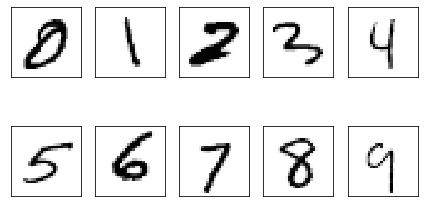

In [4]:
# visualize samples digits
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)

ax = ax.flatten()
for i in range(10):
    img = np.array(XTrain[yTrain == i].iloc[0]).reshape(28, 28)
    ax[i].imshow(img, cmap="Greys")

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

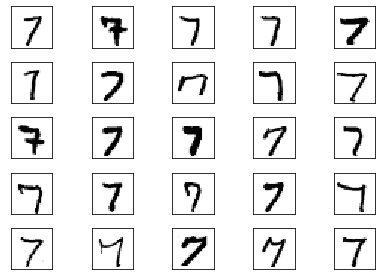

In [5]:
# visualize multiple samples of the same digit
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)

ax = ax.flatten()
for i in range(25):
    img = np.array(XTrain[yTrain == 7].iloc[i]).reshape(28, 28)
    ax[i].imshow(img, cmap="Greys")

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

# Implementing a multilayer perceptron

<a id = 'Implementing-a-multilayer-perceptron'></a>

## Homegrown implementation

<a id = 'Homegrown-implementation'></a>

In [6]:
# multilayer perceptron custom class
class NeuralNetMLP:
    """
    Info:
        Description:
            Feedforward neural network / Multilayer perceptron classifier
        Parameters:
            n_hidden : int, default = 30
                Number of hidden units
            l2 :  float, default = 0.
                Lambda value for L2-regularization
                No regularization if l2 = 0.
            epochs : int (default : 100)
                Number of passes through training set
            eta : float, default = 0.001
                Learning rate
            shuffle : boolean, default = True
                Shuffle data after every epoch if True to prevent circles
            minibatch_size : int, default = 1
                # of training samples per mini batch
            seed : int, default = None
                Random seed for weight initialization and shuffling
        Attributes:
            eval_ : dict
                Dictionary that collects cost, training accuracy and validation
                accuracy for each epoch during training
    """

    def __init__(
        self,
        n_hidden=30,
        l2=0.0,
        epochs=100,
        eta=0.001,
        shuffle=True,
        minibatch_size=1,
        seed=None,
    ):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        """
        Info:
            Description:
                Encode labels into one-hot representation
            Parameters:
                y : numpy array
                    Target values
                n_classes : int
                    Number of unique classes
            Returns:
                onehot : array, shape = (n_samples, n_labels)
        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.0
        return onehot.T

    def _sigmoid(self, z):
        """
        Info:
            Description:
                Compute logistic function (sigmoid)
            Parameters:
                z : float
                    net input
        """
        return 1.0 / (1.0 + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """
        Info:
            Description:
                Compute forward propagation step
            Parameters:
                X : array
                    Input data
        """
        # step 1: net input of hidden layer
        # [n_samples, n_features] dot [n_features, n_hidden] -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)

        # step 3: net input of output layer
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels] -> [n_samples, n_classlabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: activation of output layer
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """
        Info:
            Description:
                Compute cost function
            Parameters:
                y_enc : array, shape = (n_samples, n_labes)
                    one-hot encoded class labels
                output : array, shape = (n_samples, n_output_units)
                    Activation of the output layer (forward propagation)
            Returns:
                cost : float
                    Regularized cost of epoch
        """
        L2_term = self.l2 * (np.sum(self.w_h ** 2.0) + np.sum(self.w_out ** 2.0))
        term1 = -y_enc * (np.log(output))
        term2 = (1.0 - y_enc) * np.log(1.0 - output)
        cost = np.sum(term1 - term2) + L2_term
        return cost

    def predict(self, X):
        """
        Info:
            Description:
                Predict class labels
            Parameters:
                X : array, shape = [n_samples, n_features]
            Returns:
                y_pred : array, shape = [n_samples]
                    Predicted class labels
        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, XTrain, yTrain, XValid, yValid):
        """
        Info:
            Description:
                Learn weights from training data
            Parameters:
                XTrain : array, shape = [n_samples, n_features]
                    Input layer with original features
                yTrain : array, shape = [n_samples]
                    Correct target labels
                XValid : array, shape = [n_samples, n_features]
                    Sample features for validation during training
                yValid : array, shape = [n_samples]
                    Sample labels
        """
        n_output = np.unique(yTrain).shape[0]  # number of class labels
        n_features = XTrain.shape[1]

        #######################
        # weight initialization

        # weights for input to hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(
            loc=0.0, scale=0.1, size=(n_features, self.n_hidden)
        )

        # weights for hidden to output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(
            loc=0.0, scale=0.1, size=(self.n_hidden, n_output)
        )

        epoch_strlen = len(str(self.epochs))  # for progr. format
        self.eval_ = {"cost": [], "train_acc": [], "valid_acc": []}

        y_train_enc = self._onehot(yTrain, n_output)

        # iterate over training epochs
        for i in range(self.epochs):
            # iterate over mini batches
            indices = np.arange(XTrain.shape[0])
            if self.shuffle:
                self.random.shuffle(indices)
            for start_idx in range(
                0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size
            ):
                batch_idx = indices[start_idx : start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(XTrain[batch_idx])

                #######################
                # backpropagation

                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]

                # [n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1.0 - a_h)

                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden] -> [n_samples, n_hidden]
                sigma_h = np.dot(sigma_out, self.w_out.T) * sigmoid_derivative_h

                # [n_features, n_samples] dot [n_samples, n_hidden] -> [n_features, n_hidden]
                grad_w_h = np.dot(XTrain[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)

                # [n_hidden, n_samples] dot [n_samples, n_classlabels] -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)

                # regularization and weight updates
                delta_w_h = grad_w_h + self.l2 * self.w_h
                delta_b_h = grad_b_h  # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = grad_w_out + self.l2 * self.w_out
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #######################
            # evaluation
            z_h, a_h, z_out, a_out = self._forward(XTrain)

            cost = self._compute_cost(y_enc=y_train_enc, output=a_out)

            y_train_pred = self.predict(XTrain)
            y_valid_pred = self.predict(XValid)

            train_acc = (np.sum(yTrain == y_train_pred)).astype(
                np.float
            ) / XTrain.shape[0]
            valid_acc = (np.sum(yValid == y_valid_pred)).astype(
                np.float
            ) / XValid.shape[0]

            sys.stderr.write(
                "\r%0*d/%d | Cost: %.2f | Train/Valid Accuracy: %.2f%%/%.2f%%"
                % (
                    epoch_strlen,
                    i + 1,
                    self.epochs,
                    cost,
                    train_acc * 100,
                    valid_acc * 100,
                )
            )
            sys.stderr.flush()

            self.eval_["cost"].append(cost)
            self.eval_["train_acc"].append(train_acc)
            self.eval_["valid_acc"].append(valid_acc)

        return self

In [7]:
# initialize a 784-100-10 MLP - a neural network with 784 samples,
# 100 hidden units and 10 output units
nn = NeuralNetMLP(
    n_hidden=100,
    l2=0.01,
    epochs=50,
    eta=0.0005,
    minibatch_size=100,
    shuffle=True,
    seed=1,
)

# train neural network using first 30,000 training samples
# and use the remainder for validation
nn.fit(
    XTrain=XTrain.values[:30000],
    yTrain=yTrain.values[:30000],
    XValid=XTrain.values[30000:],
    yValid=yTrain.values[30000:],
)

50/50 | Cost: 12305.40 | Train/Valid Accuracy: 94.21%/92.83%

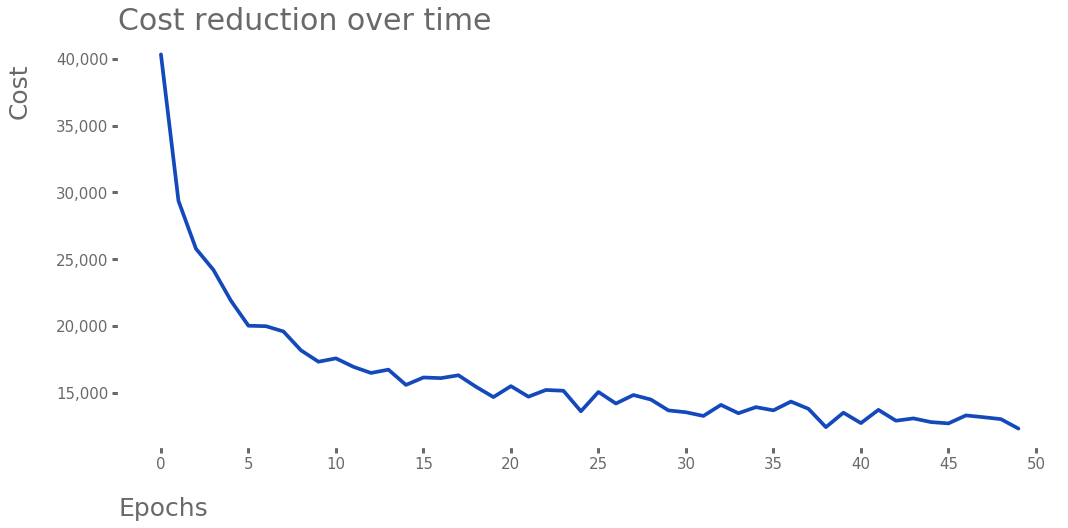

In [8]:
# plot cost over the 200 epochs
p = PrettierPlot()
ax = p.makeCanvas(
    title="Cost reduction over time", xLabel="Epochs", yLabel="Cost", yShift=0.8
)
p.prettyLine(
    x=np.arange(nn.epochs),
    y=np.array(nn.eval_["cost"]),
    linecolor=style.styleHexMid[0],
    xTicks=np.arange(0, 51, 5),
    bbox=(1.2, 0.9),
    markerOn=False,
    ax=ax,
)

> Remarks - The cost decreased substantially over the first 100 epochs before slowing afterwards. Even after the 100th epoch, it seems there is gradual improvement and would likely be more if this were allowed to run for more epochs.

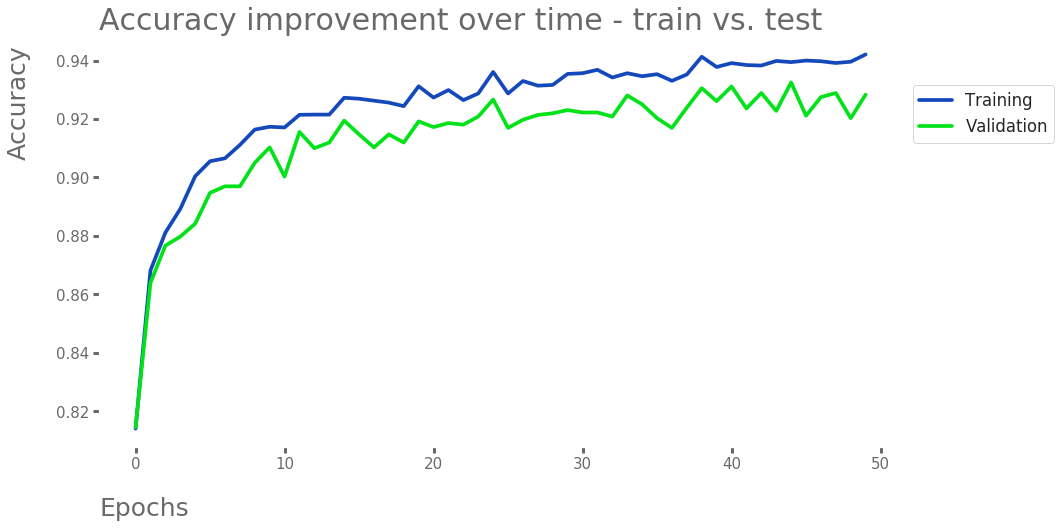

In [9]:
# plot cost over the 200 epochs
p = PrettierPlot()
ax = p.makeCanvas(
    title="Accuracy improvement over time - train vs. test",
    xLabel="Epochs",
    yLabel="Accuracy",
    yShift=0.7,
)
p.prettyMultiLine(
    x=np.arange(nn.epochs),
    y=np.c_[nn.eval_["train_acc"], nn.eval_["valid_acc"]],
    label=["Training", "Validation"],
    xUnits="f",
    yUnits="fff",
    bbox=(1.2, 0.9),
    markerOn=False,
    ax=ax,
)

> Remarks - The plot shows an increasing gap between the training and validation increases. 

In [10]:
# calculate the prediction accuracy on test
yTestPred = nn.predict(XTest)
acc = np.sum(yTest == yTestPred).astype(np.float) / XTest.shape[0]
print("Test accuracy: {:.2f}%".format(acc * 100))

Test accuracy: 93.17%


> Remarks - Despite overfitting on the training data, this model performed pretty well by achieving 97.54 percent accuracy on the unseen test data. To further refine the model, we can adjust the number of hidden units, the regularization parameter, the learning rate, among other things.



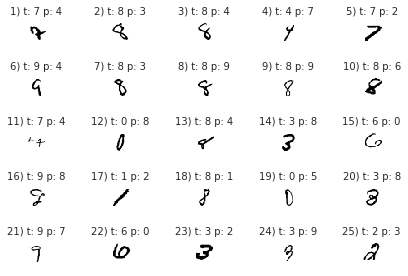

In [11]:
# review some of the misclassified images
miscl_img = XTest[yTest != yTestPred][:25]
actual_label = yTest[yTest != yTestPred][:25]
predicted_label = yTestPred[yTest != yTestPred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)

ax = ax.flatten()
for i in range(25):
    img = np.array(miscl_img.iloc[i]).reshape(28, 28)
    ax[i].imshow(img, cmap="Greys", interpolation="nearest")
    ax[i].set_title(
        "%d) t: %d p: %d" % (i + 1, actual_label.iloc[i], predicted_label[i]),
        fontsize=10,
    )

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

# Training an artificial neural network

<a id = 'Training-an-artificial-neural-network'></a>

## Logistic cost function refresher

With linear regression, we seek to minimize the sum of squares to learn the weights of the models. We did this by minimizing this cost function:

$$
J(\textbf{w}) = \sum_i\frac{1}{2}\big(\phi(z^i) - y^i\big)^2
$$

With the logistic cost function, we want to maximize likelihood. Assuming the samples in our dataset are independent of one another, likelihood $L$ is defined as:

$$
L(\textbf{x}) = P(\textbf{y}\vert\textbf{x};\textbf{w}) = \prod^n_{i=1}P(y^i\vert\textbf{x}^i;\textbf{w}) = \prod^n_{i=1}\big(\phi\big(z^i\big)\big)^{y^i}\big(1-\phi\big(z^i\big)\big)^{1-y^i}
$$

The crux of this function is the logistic sigmoid function:

$$
\phi(z) = \frac{1}{1+e^{-z}}
$$

Where z is the net input, which is the linear combination of weights and sample feature values: $z = w_0x_0 + w_1x_1 + ... + w_mx_m$

And in practice, it is more straightforward to maximize the (natural) log of the cost function, which is called the log likelihood function:

$$
l(\textbf{w}) = \mbox{log}L(\textbf{w}) = \sum^n_{i=1}\bigg[y^i\mbox{log}\big(\phi\big(z^i\big)\big) + \big(1-y^i\big)\mbox{log}\big(1-\phi(z^i)\big)\bigg]
$$

Applying the log function reduces the potential for numerical underflow, which can occur if the likelihoods are very small. Further, converting the product of factors into a summation of factors makes it easier to obtain the derivative of this function. With this cost function, we can either maximize it using gradient ascent or rewrite it as a cost function to be minimized. This function can be rewritten as:

$$
J(\textbf{w}) = \sum^n_{i=1}\bigg[-y^i\mbox{log}\big(\phi\big(z^i\big)\big) - \big(1-y^i\big)\mbox{log}\big(1-\phi(z^i)\big)\bigg]
$$

To better understand this function, we can look at the cost that we calculate for one training sample:

$$
J(\phi(z),y;\textbf{w}) = -y\mbox{log}\big(\phi\big(z\big)\big) - \big(1-y\big)\mbox{log}\big(1-\phi(z)\big)
$$

The first term becomes zero if $y$ = 0 and the second term becomes zero if $y$ = 1, so this cost function can be reshaped as:

$$
J(\phi(z),y;\textbf{w}) =
\left\{
    \begin{array}{ll}
        -y\mbox{log}\big(\phi\big(z\big)\big)  & \mbox{if } y = 1 \\
        -\mbox{log}\big(1-\phi(z)\big)  &\mbox{if } y = 0
    \end{array}
\right.
$$



<a id = 'Logistic-cost-function-refresher'></a>

(0, 5)

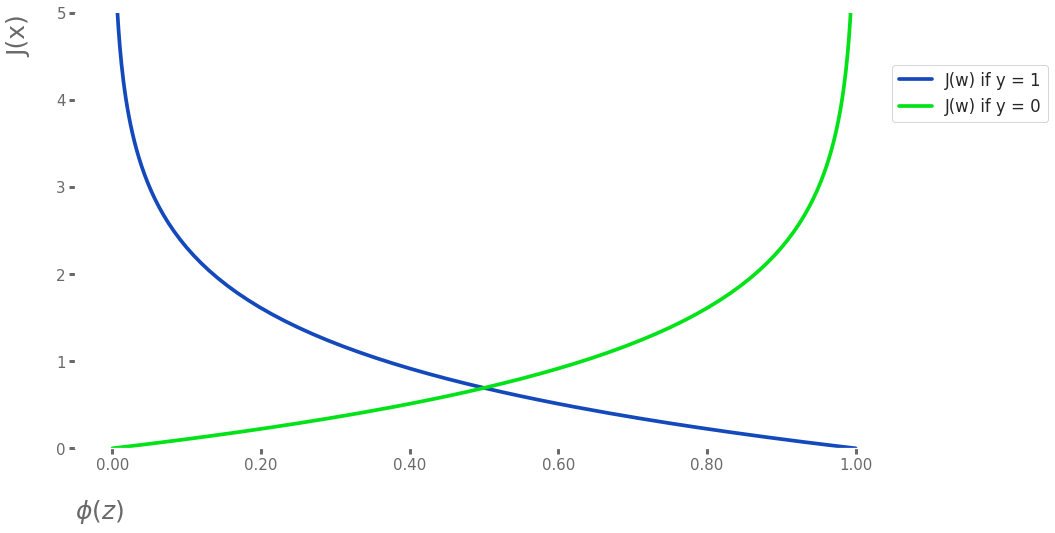

In [12]:
# plot cost function for y = 0 and y = 1
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


def cost_1(z):
    return -np.log(sigmoid(z))


def cost_0(z):
    return -np.log(1 - sigmoid(z))


z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
c0 = [cost_0(x) for x in z]
c = np.c_[c1, c0]

# plot
p = PrettierPlot()
ax = p.makeCanvas(title="", xLabel="$\phi(z)$", yLabel="J(x)", yShift=0.9)
p.prettyMultiLine(
    x=phi_z,
    y=c,
    label=["J(w) if y = 1", "J(w) if y = 0"],
    xUnits="fff",
    yUnits="f",
    bbox=(1.2, 0.9),
    markerOn=False,
    ax=ax,
)
plt.ylim(0, 5)

> Remarks - The key takeaway is seeing how the cost J(w) drastically increases for each curve as the prediction becomes further away from the truth.

## Computing the logistic cost function

$$
J(\textbf{w}) = -\sum^n_{i=1}y^i\mbox{log}\big(a^i\big) + \big(1-y^i\big)\mbox{log}\big(1-a^i\big)
$$

where $a^i$ is the sigmoid activation function of the $i$th sample in the dataset, which is computed in the forward propagation step: $a^i = \phi(z^i)$. The $i$ superscript refers to a specific training sample index, not a neural net layer.

We can add a regularization term to reduce the degree of overfitting:

$$
J(\textbf{w}) = -\bigg[\sum^n_{i=1}y^i\mbox{log}\big(a^i\big) + \big(1-y^i\big)\mbox{log}\big(1-a^i\big)\bigg] + \frac{\lambda}{2}\Vert\textbf{w}\Vert^2_2
$$

This MLP is built to perform multiclass classification, and returns an output vector of $t$ elements that gets compared to the 1 x $t$ dimensional target vector in the one-hot encoding representation. As an example, the activation of the third layer and the target class 2 for a particular sample may look like:

$$
a^{out} 
= 
\begin{bmatrix} 0.1 \\ 0.9 \\ \vdots \\  0.3 \end{bmatrix}
, y = 
\begin{bmatrix} 0 \\ 1 \\ \vdots \\  0 \end{bmatrix}
$$ 

Because of this, we need to generalize the logistic cost function to all $t$ activation units in our network. So it becomes the following:

$$
J(\textbf{W}) = -\sum^n_{i=1}\sum^t_{j=1}y^i_j\mbox{log}\big(a^i_j\big) + \big(1-y^i_j\big)\mbox{log}\big(1-a^i_j\big)
$$

The $i$ again refers to the index of a specific training sample. Here is the full function with the regularization term added:

$$
J(\textbf{W}) = -\bigg[\sum^n_{i=1}\sum^t_{j=1}y^i_j\mbox{log}\big(a^i_j\big) + \big(1-y^i_j\big)\mbox{log}\big(1-a^i_j\big)\bigg] + \frac{\lambda}{2}\sum_{l=1}^{L-1}\sum_{i=1}^{\mu_l}\sum_{j=1}^{\mu_{l+1}}(w^l_{j,i})^2
$$

This generalized regularization term calculates the sum of all weights of an $l$ layer. $\mu_1$ refers to the number of units in a given layer $l$. To minimize this cost function, we need to calculate the partial derivative of the parameters $\textbf{W}$ with respect to each weight in every layer of the network:

$$
\frac{\partial}{\partial(w^l_{j,i})}J(\textbf{W})
$$

It's important to note that $\textbf{W}$ consists of multiple matrices. In an MLP with one hidden unit, we have the weight matrix $\textbf{W}^h$ that connects the input layer to the hidden layer, and $\textbf{W}^{out}$ that connects the hidden layer to the output layer. This is a three dimensional tensor.

For $\textbf{W}^h$, the rows represent the features, and the columns represent the hidden units. One particular value represents the weight that a certain hidden unit has for a certain feature. For $\textbf{W}^{out}$, the rows represent the hidden units, and the columns represent the output units.  The matrices in this tensor do not necessarily have the same shape. This only occurs if the MLP is initialized with the samenumber of hidden units, output units and input feautres.

<a id = 'Computing-the-logistic-cost-function'></a>

## Developing intuition for backpropagation

Backpropagation is one of the most widely use algorithms for efficiently training neural networks. It is a very computationally efficient approach to compute the partial derivatives of a complex cost function in MLPs. The goal is to use the derivatives to learn the weight coefficients. The challenging aspect of weight determination in an MLP is that we are typically dealing with a very large number of weight coefficients in a high-dimensional feature space. Further, the error surface of a neural network cost function is not convex or smooth with respect to the parameters, unlike single layer networks such as Adaline or logistic regression. There will be many local minima that need to be overcome in order to find teh global minimum of the cost function.

This calls forth the calculcus concept of the chain rule, which is a useful trick for finding the derivative of a complex, nested function like $f(g(x))$

$$
\frac{d}{dx}\bigg(f\big(g(x)\big)\bigg) = \frac{df}{dg} \cdot \frac{dg}{dx}
$$

The chain rule can be used for an arbitrarily long function. Even if we have five different functions $f(x)$, $g(x)$, $h(x)$, $u(x)$ and $v(x)$, where $F$ is the function composition $F(x) = f(g(h(u(v(x)))))$. The derivative of this function is:

$$
\frac{dF}{dx} = \frac{d}{dx}F(x) = \frac{d}{dx}f(g(h(u(v(x))))) = \frac{df}{dg} \cdot \frac{dg}{dh} \cdot \frac{dh}{du} \cdot \frac{du}{dv} \cdot \frac{dv}{dx}
$$

Automatic differentiation is a technique for solving these kinds of problems efficiently. It comes in two modes, forward and reverse. Backpropagation is a special case of rever mode automatic differentiation. The key point is that applying the chain rule in the forward mode would be expensive since we need to multiply large matrices for each layer (Jacobians) that are eventually multiplied by a vector to obtain the output. The trick within the reverse mode is that we start from right to left: we multiply a matrix by a vector, which yields another vector that is multiplied by the next matrix, and so on. Matrix-vector multiplication is much cheaper computationally that matrix-matrix multiplication, which makes backpropagation very popular in this space.


<a id = 'Developing-your-intuition-for-backpropagation'></a>

## Training neural networks via backpropagation

Earlier we showed how to calculate the cost as the difference between the activation of the last layer and the actual target class label. To get here, we need to apply forward propagation in order to obtain the activaiton of the output layer:

$$
\textbf{Z}^{h} = \textbf{A}^{in}\textbf{W}^{h} \ \mbox{(net input of the hidden layer)} 
\\
\textbf{A}^{h} = \phi(\textbf{Z}^{h}) \ \mbox{(activation of the hidden layer)}
\\
\textbf{Z}^{out} = \textbf{A}^{h}\textbf{W}^{out} \ \mbox{(net input of the output layer)}
\\
\textbf{A}^{out} = \phi(\textbf{Z}^{out}) \ \mbox{(activation of the output layer)}
$$

Following that calculation, backpropagation is used to update the weights in the MLP model. The error is propagated from the right to the left. This start by first calculating the error vector of the output layer:

$$
\mathbf{\delta^{out}} = \mathbf{a^{out}} - \textbf{y}
$$

$\textbf{y}$ is the vector of the true class labels. In the homegrown implementation, this is the 'sigma_out variale. Next, calculate the rror term of the hidden layer:

$$
\mathbf{\delta^{h}} = \mathbf{\delta^{out}}\big(\mathbf{W^{out}}\big) \odot \frac{\partial\phi(z^h)}{\partial z^h}
$$

The right most term is just the derivative of the sigmoid activation function, which is:
$$
\frac{\partial\phi(z^h)}{\partial z^h} = \big(a^h \odot (1-a^h)\big)
$$

The symbol $\odot$ stands for element-wise multiplication, which is simply the multiplication of elements in separate matrices that share the same position (when using two equally sized matrices). Element-wise multiplication can also occur between a vector and a matrix as the the rows are equal.

After that, compute the $\delta^h$ layer error matrix (value 'sigma_h' in the homegrowm implementation):

$$
\delta^h = \delta^{out}\big(\textbf{W}^{out}\big)^T \odot \bigg(a^h \odot \big(1 - a^h\big)\bigg)
$$

The $\delta^h$ term was calculated by taking the transpose $\big(\textbf{W}^{out}\big)^T$ of the $h$ x $t$ dimensional matrix $\textbf{W}^{out}$. The value $t$ is the number of output class labels and $h$ is the number of hidden units. Multiplying $\big(\textbf{W}^{out}\big)^T$ by the $n$ x $t$ dimensional $\mathbf{\delta}^{out}$ results in an $n$ x $t$ dimensional matrix that is multiplied elementwise by the sigmoid function derivative that is also of $n$ x $t$ dimension to ultimately obtain $\delta^h$.

Now that we have all of the $\delta$ terms, we can write the derivation of the cost function as follows:

$$
\frac{\partial}{\partial w_{i,y}^{out}}\mathbf{J(W)} = a_j^h\delta_i^{out}
\\
\frac{\partial}{\partial w_{i,y}^{h}}\mathbf{J(W)} = a_j^{in}\delta_i^{h}
$$

Next, we need to accumulate the partial derivative of every node in each layer and the error of the node in the next layer. This requires that we compute $\Delta_{i,j}^l$ for every sample in the training set. This vectorized implementation of this is as follows:

$$
\Delta^h = \Delta^h + \big(\textbf{A}^{in}\big)^T \delta^h
\\
\Delta^{out} = \Delta^{out} + \big(\textbf{A}^{h}\big)^T \delta^{out}
$$

And after accumulating the partial derivatives, we can dd the regularization term:

$$
\Delta^t := \Delta^t + \lambda^l \ \mbox{(except for the bias term)}
$$

The two immediate mathematical expression above correspond to the variables 'delta_w_h',  'delta_b_h', 'delta_w_out' and 'delta_b_out'. Lastly, after computing the gradients, we can now updates the weights by taking an opposite step towards the gradient for each layer $l$:

$$
\textbf{W}^t := \textbf{W}^t - \eta\Delta^t
$$

<a id = 'Training-neural-networks-via-backpropagation'></a>